# 10. Logistic Regression

## 10.4 Robust logistic regression

### 10.4.2 Bi-tempered loss

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The __tempered logarithm__ $\log_t\colon\mathbb{R}_+\to\mathbb{R}$ for $t\geq 0$, is defined by
$$
\log_t x \equiv \frac{1}{1-t}(x^{1-t}-1)
$$
and the __tempered exponential__ $\exp_t\colon\mathbb{R}\to\mathbb{R}_+$ for $t>1, is defined by
$$
\exp_t x \equiv \bigl[ 1 + (1-t)x \bigr]_+^\frac{1}{1-t}
$$
where $[\;\cdot\;]_+ = \max\{\;\cdot\,,0\}$.

In [2]:
def log_t(x, t):
    if t == 1:
        return np.log(x)
    else:
        onemt = 1.0 - t
        return (x ** onemt - 1.0) / onemt

def exp_t(x, t):
    if t == 1:
        return np.exp(x)
    else:
        onemt = 1.0 - t
        return np.maximum(0.0, 1.0 + onemt * x) ** (1.0 / onemt)

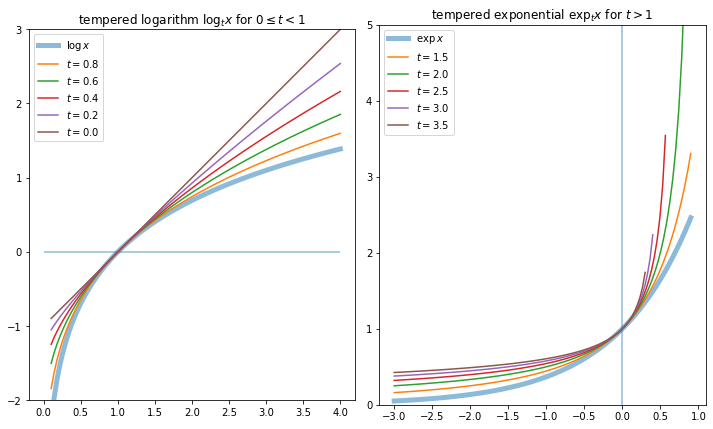

In [3]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,6))

# tempered logarithm
x = np.linspace(0.1, 4, 100)
ax1.hlines(0, xmin=0, xmax=4, alpha=0.5)
ax1.plot(x, log_t(x, 1), lw=5, alpha=0.5, label=f'$\\log x$')
for t in np.arange(0.8, -0.1, -0.2):
    ax1.plot(x, log_t(x, t), label=f'$t={t:.1f}$')
ax1.set_aspect('equal')
ax1.set_ylim([-2, 3])
ax1.set_title('tempered logarithm $\log_t x$ for $0\leq t<1$')
ax1.legend(loc='upper left')

# tempered exponential
ax2.vlines(0, ymin=0, ymax=5, alpha=0.5)
x = np.linspace(-3, 0.9, 100)
ax2.plot(x, exp_t(x, 1), lw=5, alpha=0.5, label=f'$\\exp x$')
for t in np.arange(1.5, 4.0, 0.5):
    x = np.linspace(-3, min(1, 1/(t-1))-0.1, 100)
    ax2.plot(x, exp_t(x, t), label=f'$t={t:.1f}$')
ax2.set_aspect('equal')
ax2.set_ylim([0, 5])
ax2.set_title('tempered exponential $\exp_t x$ for $t>1$')
ax2.legend(loc='upper left')

fig.tight_layout()

#### Algorithm 3: Iterative algorithm for computing $\lambda(a)$ in Equation (10.107). [AWS19]

![](algorithm_10.3.png)

In [4]:
def compute_normalization(a, t, n_iters=10, tol=1e-05):
    """
    Run iterative algorithm for computing normalization

    Args
        a: array with `n_classes` as the last dimension
        t: temperature (> 1.0 for tail heaviness)
        n_iters: number of iteration to run the algorithm
        tol: tolerance to stop iteration using Frobenius norm

    Return
        tensor of shape a.shape[:-1] 
    """
    assert t >= 1.0, f"Temperature({t}) must greater or equal to one."
    mu = np.max(a, axis=-1, keepdims=True)
    a_0 = a - mu
    
    a_k = a_0
    for _ in range(n_iters):
        Z = np.sum(exp_t(a_k, t), axis=-1, keepdims=True)
        a_kp1 = np.power(Z, 1 - t) * a_0
        if np.linalg.norm(a_kp1 - a_k) < tol:
            break
        a_k = a_kp1

    return -log_t(1.0 / Z, t) + mu

def assert_normalization(a, t):
    return np.allclose(
        np.sum(exp_t(a - compute_normalization(a, t), t), axis=-1),
        1
    )

assert_normalization(np.random.rand(10, 10), 2)

True

The __tempered cross entropy__ loss for $t_1<1<t_2$, is defined by
$$
\begin{align*}
\mathcal{L}(y,\hat y) &= \sum_c\Bigl[ y_c(\log_{t_1}y_c-\log_{t_1}\hat y_c) - \frac{1}{2-t_1}(y_c^{2-t_1}-\hat y_c^{2-t_1}) \Bigr] \\
&= \sum_c \Bigl[ \frac{y_c}{1-t_1}(y_c^{1-t_1}-\hat y_c^{1-t_1}) - \frac{1}{2-t_1}(y_c^{2-t_1}-\hat y_c^{2-t_1}) \Bigr] \\
&= -\log_{t_1}\hat y_c - \frac{1}{2-t_1}\Bigl( 1-\sum_{c'}\hat y_{c'}^{2-t_1} \Bigr) \quad\text{if $y$ one-hot with $y_c=1$}
\end{align*}
$$
where the __tempered softmax__ is given by $\hat y_c=\exp_{t_2}(a_c-\lambda_{t_2}(a))$.
Here, $\lambda_{t_2}(a)$ can be calculated using Algorithm 3.

In the binary case, set $a_1=0$ where $a=(a_1,a_2)$. Then $\hat y=\hat y_2=\exp_{t_2}(a_2-\lambda_{t_2}(a))$. In particular, when $t_2=1$, we get the sigmoid
$$
\hat y = \exp(a_2-\operatorname{lse}(a)) = \frac{\exp a_2}{1 + \exp a_2} = \sigma(a_2)
$$

In [5]:
def bi_tempered_loss(y, a, t1, t2):
    """Computes the bi-tempered logistic loss.

    Args:
    y: labels with one-hot encoding
    a: tensor with last dimension `num_classes`
    t1: Temperature 1 (< 1.0 for boundedness)
    t2: Temperature 2 (> 1.0 for tail-heaviness)

    Returns:
    a loss tensor
    """
    hat_y = exp_t(a - compute_normalization(a, t2), t2)
    twomt1 = 2.0 - t1
    loss = - np.sum(y * log_t(hat_y, t1), axis=-1)
    loss -= 1.0 / twomt1 * (1.0 - np.sum(np.power(hat_y, twomt1), axis=-1))
    
    return loss

def tempered_log_loss(x, t1=1.0, t2=1.0):
    assert len(x.shape) == 1
    a = np.stack((np.zeros_like(x), x), axis=1)
    y = np.full_like(a, [0, 1])
    loss = bi_tempered_loss(y, a, t1, t2)
    return loss

def tempered_sigmoid(x, t=1.0):
    assert len(x.shape) == 1
    a = np.stack((np.zeros_like(x), x), axis=1)
    hat_y = exp_t(a - compute_normalization(a, t), t)
    return hat_y[:,1]

x = np.linspace(-10, 5, 10)
tempered_log_loss(x), tempered_sigmoid(x)

(array([1.00000454e+01, 8.33357367e+00, 6.66793849e+00, 5.00671535e+00,
        3.36838575e+00, 1.83967466e+00, 6.93147181e-01, 1.73007989e-01,
        3.50524161e-02, 6.71534849e-03]),
 array([4.53978687e-05, 2.40311713e-04, 1.27101626e-03, 6.69285092e-03,
        3.44451957e-02, 1.58869105e-01, 5.00000000e-01, 8.41130895e-01,
        9.65554804e-01, 9.93307149e-01]))

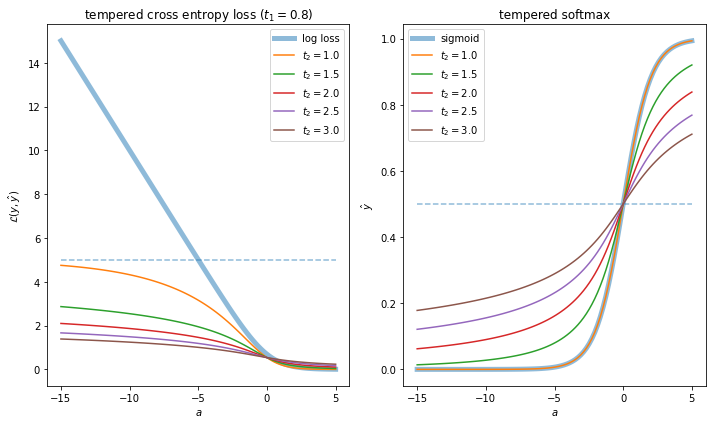

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,6))

# bi-tempered loss (t1=0.8)
x = np.linspace(-15, 5, 100)
ax1.hlines(5, xmin=-15, xmax=5, linestyles='dashed', alpha=0.5)
ax1.plot(x, tempered_log_loss(x), lw=5, alpha=0.5, label=f'log loss')
for t2 in np.arange(1.0, 3.1, 0.5):
    ax1.plot(x, tempered_log_loss(x, 0.8, t2), label=f'$t_2={t2:.1f}$')
ax1.set_xticks(range(-15, 6, 5))
ax1.set_xlabel('$a$')
ax1.set_ylabel('$\mathcal{L}(y,\hat y)$')
ax1.set_title('tempered cross entropy loss ($t_1=0.8$)')
ax1.legend(loc='upper right')

# # bi-tempered loss (t2=1.2)
# x = np.linspace(-15, 5, 100)
# #ax2.hlines(5, xmin=-15, xmax=5, linestyles='dashed', alpha=0.5)
# ax2.plot(x, bi_tempered_binary_loss(x), lw=5, alpha=0.5, label=f'logistic')
# for t1 in np.arange(1.0, -0.1, -0.2):
#     ax2.plot(x, bi_tempered_binary_loss(x, t1, 1.2), label=f'$t_1={t1:.1f}$')
# ax2.set_xticks(range(-15, 6, 5))
# ax2.set_title('bi-tempered loss ($t_2=1.2$)')
# ax2.legend(loc='upper right')

# transfer function (t2=2.0)
x = np.linspace(-15, 5, 100)
ax2.hlines(0.5, xmin=-15, xmax=5, linestyles='dashed', alpha=0.5)
ax2.plot(x, tempered_sigmoid(x, 1), lw=5, alpha=0.5, label=f'sigmoid')
for t2 in np.arange(1.0, 3.1, 0.5):
    ax2.plot(x, tempered_sigmoid(x, t2), label=f'$t_2={t2:.1f}$')
ax2.set_xticks(range(-15, 6, 5))
ax2.set_xlabel('$a$')
ax2.set_ylabel('$\hat y$')
ax2.set_title('tempered softmax')
ax2.legend(loc='upper left')

fig.tight_layout()